## Initial Data Cleaning ##

Collects and unifies primary and secondary school data where the anonymized student is present in both.

In [1]:
import csv
import os
import pandas as pd
import numpy as np

In [2]:
# Check files in the Raw Data folder
os.listdir('../Data/Raw')

['Avaluacio_de_quart_dEducacio_Secundaria_Obligatoria_20251113.csv',
 'Avaluacio_de_sise_deducacio_primaria_20251113.csv']

In [3]:
#csv_path = os.path.abspath("../Data/Raw/Avaluacio_de_quart_dEducació_Secundaria_Obligatoria_20251111.csv")

# GENERAL OPTION: Take the first file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()
df_S = pd.DataFrame(secondary_data)

# Second file in the Raw Data folder
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])
primary_data = []
with open(csv_path) as data: 
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()
df_P = pd.DataFrame(primary_data)

In [4]:
df_P.columns = df_P.iloc[0]    # set first row as header
df_P = df_P[1:]                # drop the first row (since it's now the header)
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]    # set first row as header
df_S = df_S[1:]                # drop the first row (since it's now the header)
df_S.reset_index(drop=True, inplace=True)

In [5]:
df = pd.DataFrame({'CODI_ALUMNE': pd.concat([df_P['CODI_ALUMNE'], df_S['CODI_ALUMNE']]).unique()})
df['in_P'] = df['CODI_ALUMNE'].isin(df_P['CODI_ALUMNE']) 
df['in_S'] = df['CODI_ALUMNE'].isin(df_S['CODI_ALUMNE'])
matching = df[df['in_P'] & df['in_S']] 

# Keep only rows from df_P where CODI_ALUMNE exists in both
df_P_matching = df_P[df_P['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()
# Keep only rows from df_S where CODI_ALUMNE exists in both
df_S_matching = df_S[df_S['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()

df_P_matching.reset_index(drop=True, inplace=True)
df_S_matching.reset_index(drop=True, inplace=True)

In [6]:
common_cols = set(df_P_matching.columns) & set(df_S_matching.columns)

In [7]:
print(df_P.columns)
print(df_S.columns)

Index(['ANY', 'CODI_ALUMNE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL',
       'PCAST_EE', 'PMAT', 'PMAT_NC', 'PMAT_EFM', 'PMAT_CR', 'PANG', 'PANG_CO',
       'PANG_CE', 'PFRAN', 'PFRAN_CO', 'PFRAN_CE', 'PANG_EE', 'PFRAN_EE',
       'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3',
       'GENERE', 'MES_NAIXEMENT', 'ANY_NAIXEMENT', 'AREA_TERRITORIAL',
       'NATURALESA', 'HABITAT'],
      dtype='object', name=0)
Index(['ANY', 'CODI_ALUMNE', 'PCAT', 'PCAT_CL', 'PCAT_EE', 'PCAST', 'PCAST_CL',
       'PCAST_EE', 'PANG', 'PANG_CO', 'PANG_CL', 'PANG_EE', 'PFRAN',
       'PFRAN_CO', 'PFRAN_CL', 'PFRAN_EE', 'PMAT', 'PMAT_EFM', 'PMAT_CR',
       'PMAT_EST', 'PMAT_NC', 'PALE', 'PALE_CO', 'PALE_CL', 'PALE_EE', 'PCIEN',
       'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3', 'PCIEN_COMP4', 'GENERE',
       'MES_NAIXEMENT', 'ANY_NAIXEMENT', 'NATURALESA', 'AREA TERRITORIAL',
       'HABITAT'],
      dtype='object', name=0)


In [8]:
# List of required columns (from your message)
required_cols = [
    'ANY', 'ANY_NAIXEMENT', 'CODI_ALUMNE', 'GENERE', 'HABITAT',
    'MES_NAIXEMENT', 'NATURALESA', 'PANG', 'PANG_CO', 'PANG_EE',
    'PCAST', 'PCAST_CL', 'PCAST_EE', 'PCAT', 'PCAT_CL', 'PCAT_EE',
    'PFRAN', 'PFRAN_CO', 'PFRAN_EE', 'PMAT', 'PMAT_CR', 'PMAT_EFM', 'PMAT_NC'
]

df_P_clean = df_P.dropna(subset=required_cols).copy()
df_S_clean = df_S.dropna(subset=required_cols).copy()

common_ids = set(df_P_clean['CODI_ALUMNE']) & set(df_S_clean['CODI_ALUMNE'])
df_P_clean = df_P_clean[df_P_clean['CODI_ALUMNE'].isin(common_ids)]
df_S_clean = df_S_clean[df_S_clean['CODI_ALUMNE'].isin(common_ids)]

df_P_clean['snapshot'] = 'past'
df_S_clean['snapshot'] = 'present'

df_combined = pd.concat([df_P_clean, df_S_clean], ignore_index=True)

df_pivot = df_combined.pivot_table(
    index='CODI_ALUMNE',
    columns='snapshot',
    values=[col for col in required_cols if col != 'CODI_ALUMNE'],
    aggfunc='first'
)

In [9]:
df_pivot

0             ANY         ANY_NAIXEMENT         GENERE          \
snapshot     past present          past present   past present   
CODI_ALUMNE                                                      
             2018    2019          2005              H       D   
100028145    2018    2022          2005    2005      D       D   
1000332771   2016    2020          2004    2004      H       H   
1000343103   2016    2020          2004    2004      D       D   
1000354325   2016    2020          2004    2004      D       D   
...           ...     ...           ...     ...    ...     ...   
999005478    2016    2020          2004    2004      H       H   
999027032    2016    2020          2004    2004      H       H   
99949376     2016    2020          2004    2004      D       D   
99961597     2019    2023          2007    2007      H       H   
99983150     2018    2022          2006    2006      D       D   

0                      HABITAT                    MES_NAIXEMENT          ...  \
snapshot                  past            present          past present  ...   
CODI_ALUMNE                                                              ...   
                MÃ©s de 100000     MÃ©s de 100000             1          ...   
100028145       MÃ©s de 100000     MÃ©s de 100000             7       7  ...   
1000332771   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000343103   De 10001 a 100000  De 10001 a 100000             1       1  ...   
1000354325   De 10001 a 100000  De 10001 a 100000            10      10  ...   
...                        ...                ...           ...     ...  ...   
999005478    De 10001 a 100000  De 10001 a 100000            11      11  ...   
999027032    De 10001 a 100000  De 10001 a 100000             9       9  ...   
99949376        MÃ©s de 100000     MÃ©s de 100000             7       7  ...   
99961597        MÃ©s de 100000     MÃ©s de 100000             7       7  ...   
99983150        MÃ©s de 100000     MÃ©s de 100000            10      10  ...   

0           PFRAN_EE           PMAT         PMAT_CR         PMAT_EFM          \
snapshot        past present   past present    past present     past present   
CODI_ALUMNE                                                                    
                              91,49          100,00            81,82           
100028145                     76,89   43,33   88,89   66,67    81,82   33.33   
1000332771                    91,59    79,8  100,00   88,89    91,67      70   
1000343103                    97,28   74,88  100,00   77,78   100,00      90   
1000354325                    94,20    97,5  100,00     100    83,43      90   
...              ...     ...    ...     ...     ...     ...      ...     ...   
999005478                     82,39   45,08   88,49   22,22    75,34      20   
999027032                     82,84   59,48   88,49   66,67    91,43      30   
99949376                      97,09   82,82  100,00   88,89    91,67      90   
99961597                      81,57   70,86   77,78    87,5    81,82    62.5   
99983150                      90,79   49,17   88,89   33,33    90,91   33.33   

0           PMAT_NC          
snapshot       past present  
CODI_ALUMNE                  
              92,86          
100028145     57,14       0  
1000332771    84,30   71,43  
1000343103    92,22   42,86  
1000354325   100,00     100  
...             ...     ...  
999005478     84,23   71,43  
999027032     69,41   85,71  
99949376     100,00   85,71  
99961597      85,71   55,56  
99983150      92,86    62,5  

[251748 rows x 44 columns]

In [10]:
df_pivot.shape[0]

251748

In [11]:
matching.shape[0]

251748

In [12]:
common_cols

{'ANY',
 'ANY_NAIXEMENT',
 'CODI_ALUMNE',
 'GENERE',
 'HABITAT',
 'MES_NAIXEMENT',
 'NATURALESA',
 'PANG',
 'PANG_CO',
 'PANG_EE',
 'PCAST',
 'PCAST_CL',
 'PCAST_EE',
 'PCAT',
 'PCAT_CL',
 'PCAT_EE',
 'PFRAN',
 'PFRAN_CO',
 'PFRAN_EE',
 'PMAT',
 'PMAT_CR',
 'PMAT_EFM',
 'PMAT_NC'}

In [13]:
# One-to-one merge by CODI_ALUMNE eliminating duplicates

print("df_P_matching: files =", len(df_P_matching),
      " unique students =", df_P_matching['CODI_ALUMNE'].nunique())

print("df_S_matching: files =", len(df_S_matching),
      " unique students =", df_S_matching['CODI_ALUMNE'].nunique())

df_P_unique = df_P_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')
df_S_unique = df_S_matching.sort_values('CODI_ALUMNE').drop_duplicates('CODI_ALUMNE')

df_merged = pd.merge(
    df_P_unique,
    df_S_unique,
    on='CODI_ALUMNE',
    how='inner',           # only keep rows present in both
    suffixes=('_P', '_S'), # distinguish the two sets of columns
    validate='one_to_one'
)


df_P_matching: files = 700990  unique students = 251748
df_S_matching: files = 489510  unique students = 251748


=== Correlations within Primary (df_P_unique) ===
Target: PMAT
0
PMAT          1.000000
PMAT_NC       0.863193
PMAT_CR       0.851235
PMAT_EFM      0.804038
PMED          0.648560
PCAT          0.606761
PCAST         0.588814
PMED_COMP3    0.562763
PANG          0.548953
PCAT_CL       0.541921
PCAST_EE      0.525628
PCAST_CL      0.525446
PMED_COMP1    0.524976
PANG_CE       0.523953
PFRAN         0.522115
PCAT_EE       0.510934
PFRAN_CO      0.478787
PMED_COMP2    0.478229
PFRAN_CE      0.465351
PCAST_CO      0.456468
PANG_CO       0.444492
PCAT_CO       0.438352
PANG_EE       0.432461
PFRAN_EE      0.410013
Name: PMAT, dtype: float64

=== Correlations within Secondary (df_S_unique) ===
Target: PMAT
0
PMAT    1.0
Name: PMAT, dtype: float64


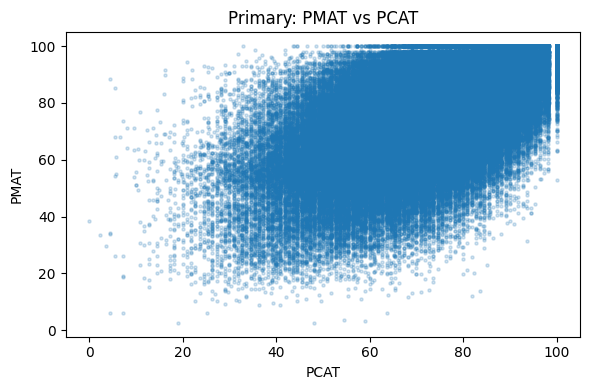

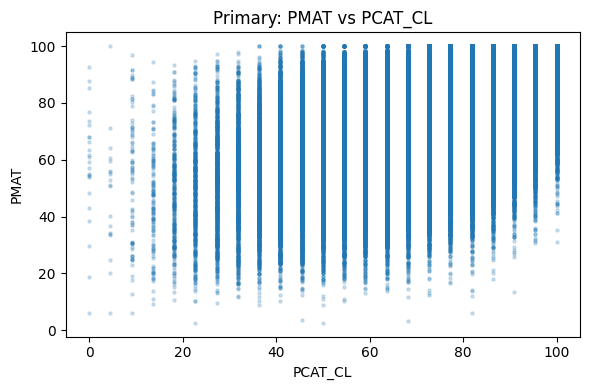

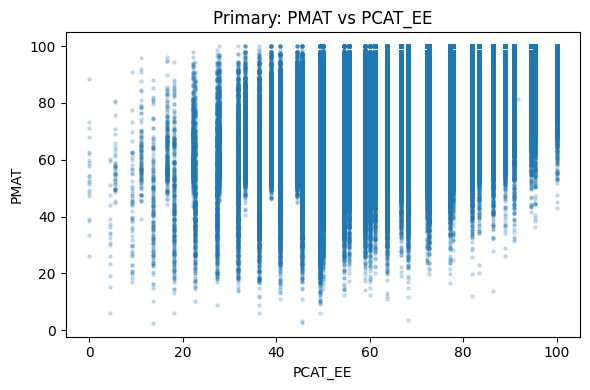

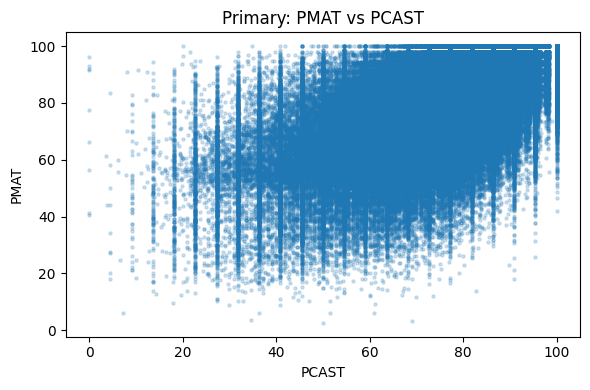

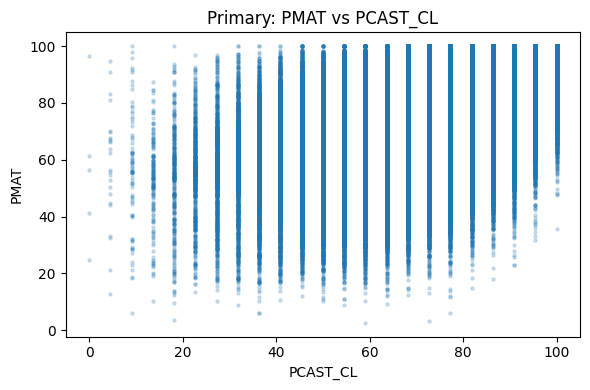

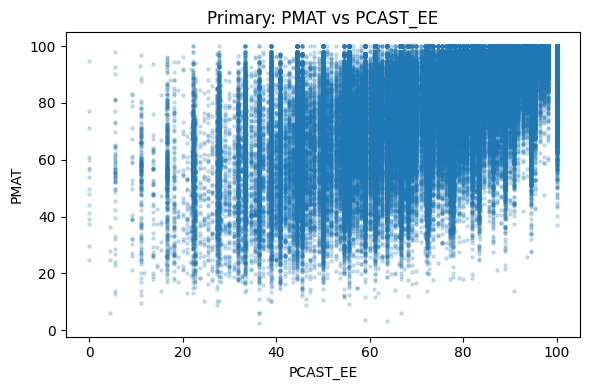

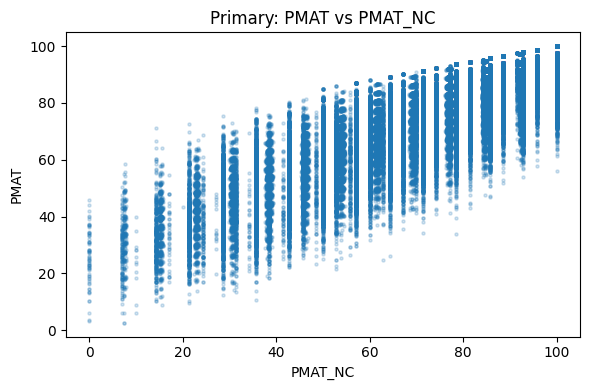

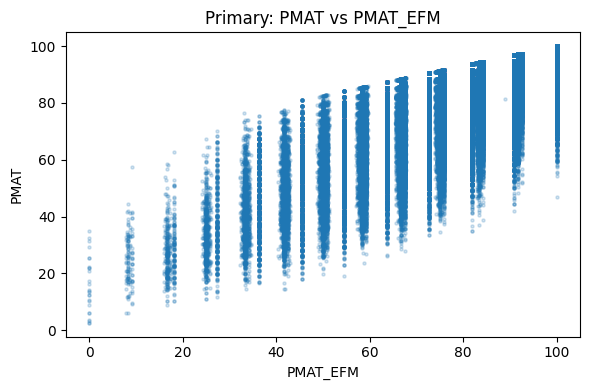

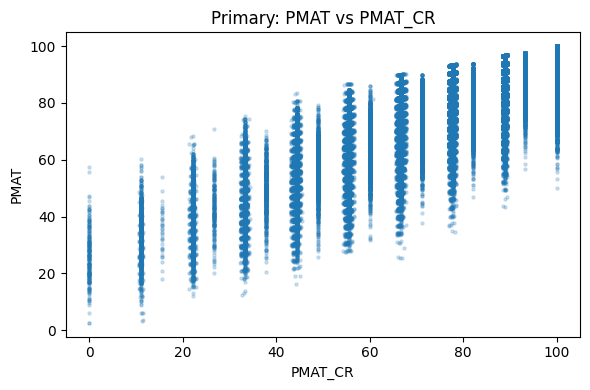

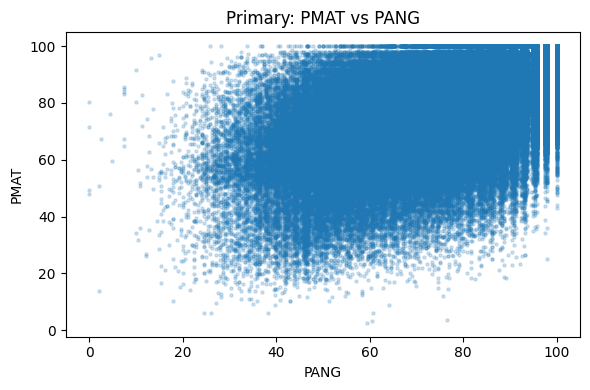

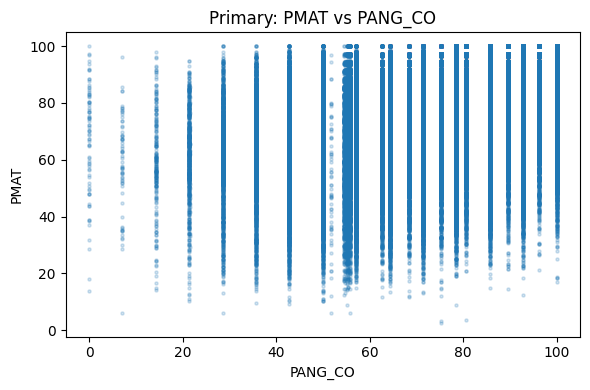

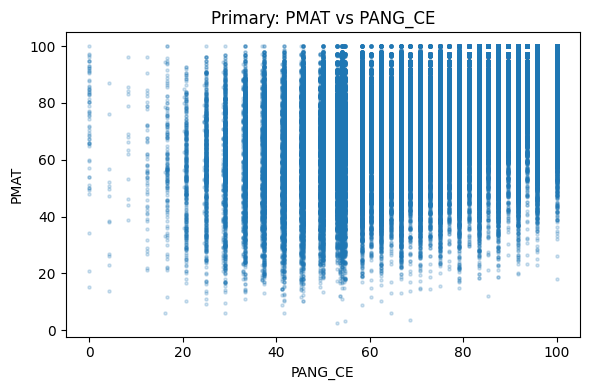

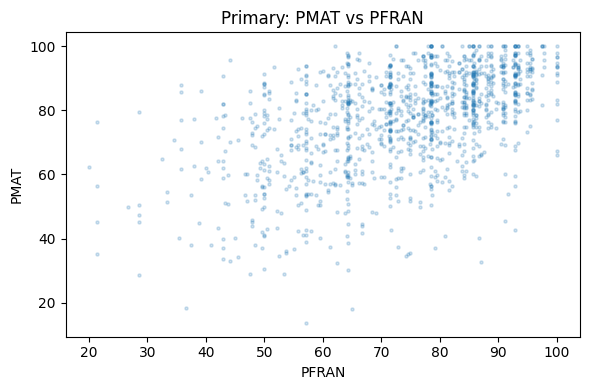

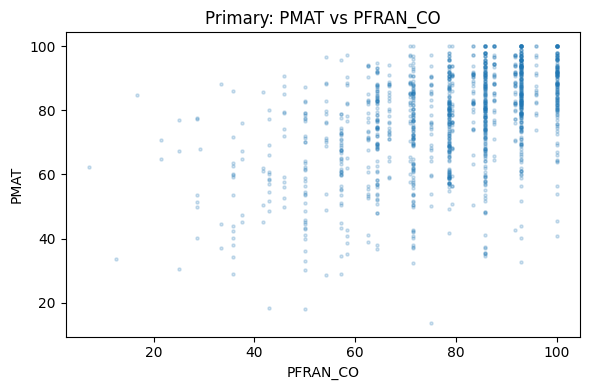

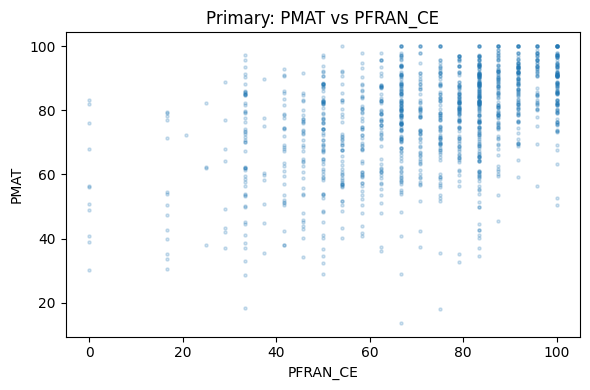

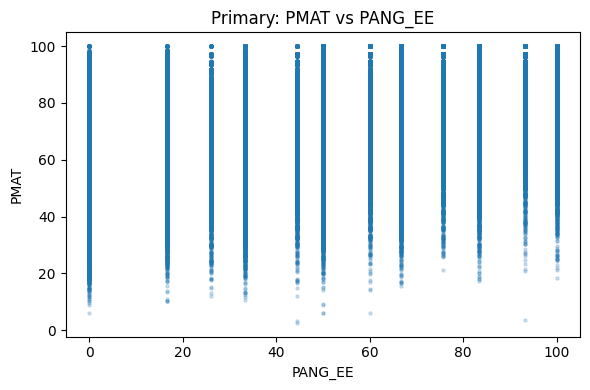

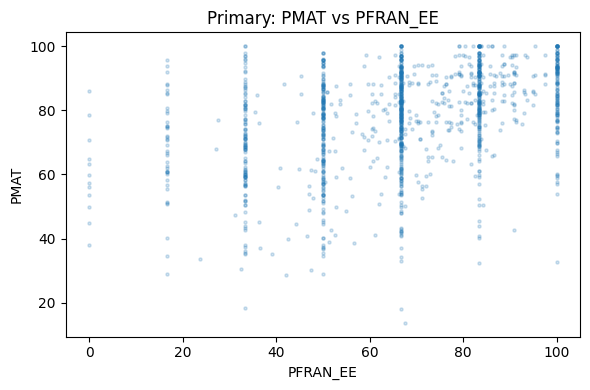

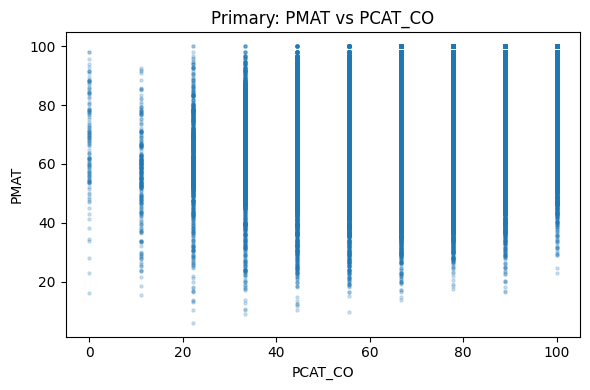

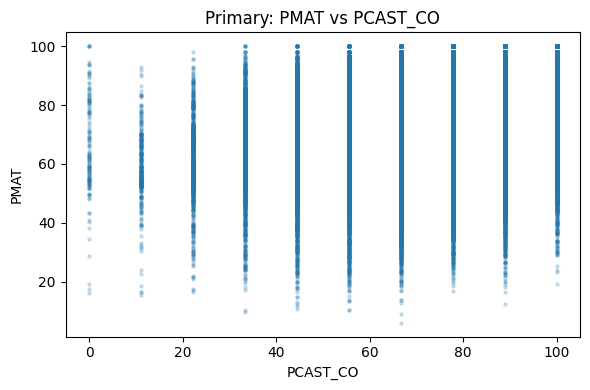

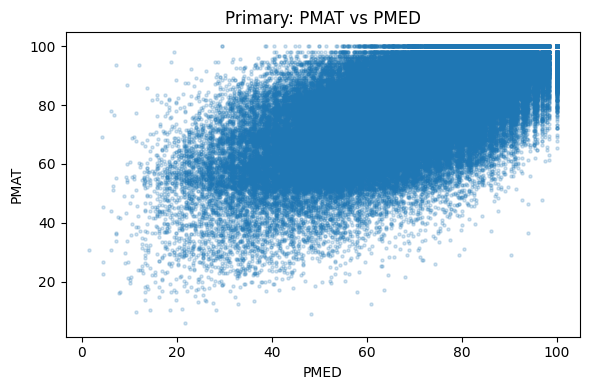

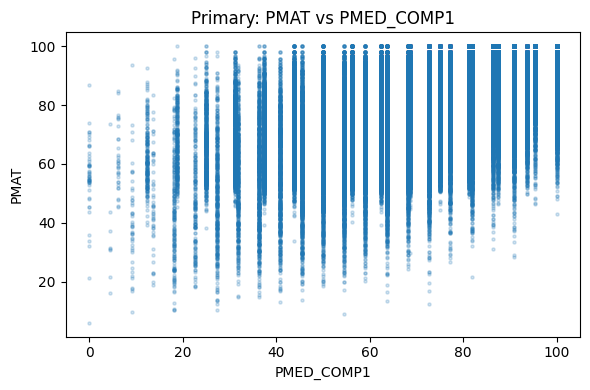

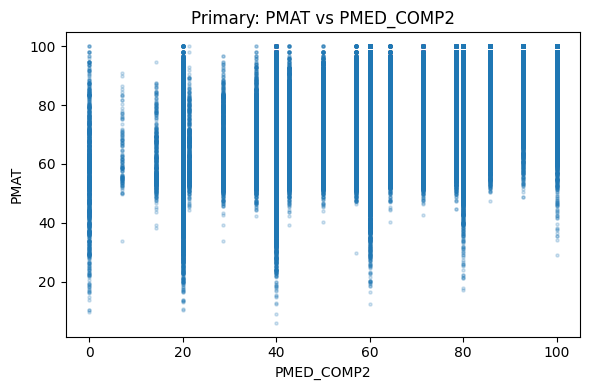

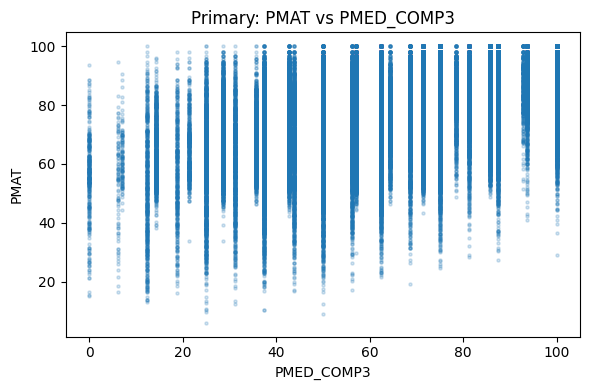

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 1. Helper: convert grade columns to numeric (comma → dot)
# ===============================
def convert_grade_columns_to_numeric(df, prefix="P"):
    """
    Convert all columns starting with a given prefix (e.g. 'P')
    from strings with comma decimals to numeric floats.
    Non-convertible values become NaN.
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix)]
    for col in grade_cols:
        # Ensure string type first
        s = df[col].astype(str)
        # Replace comma with dot for decimal conversion
        s = s.str.replace(",", ".", regex=False)
        # Convert to numeric; invalid parsing becomes NaN
        df[col] = pd.to_numeric(s, errors="coerce")
    return grade_cols  # return list of converted grade columns

# ===============================
# 2. Convert grade columns in Primary (P) and Secondary (S)
# ===============================
grade_cols_P = convert_grade_columns_to_numeric(df_P_unique, prefix="P")
grade_cols_S = convert_grade_columns_to_numeric(df_S_unique, prefix="S")

# Choose the Mathematics column name (assumes 'PMAT' exists in both)
math_col_name = "PMAT"

# Columns for correlation (all grades except Mathematics)
other_P = [c for c in grade_cols_P if c != math_col_name]
other_S = [c for c in grade_cols_S if c != math_col_name]

# ===============================
# 3. Correlations within Primary (df_P_unique)
# ===============================
corr_P = (
    df_P_unique[other_P + [math_col_name]]
    .corr(numeric_only=True)[math_col_name]
    .sort_values(ascending=False)
)

print("=== Correlations within Primary (df_P_unique) ===")
print(f"Target: {math_col_name}")
print(corr_P)

# ===============================
# 4. Correlations within Secondary (df_S_unique)
# ===============================
corr_S = (
    df_S_unique[other_S + [math_col_name]]
    .corr(numeric_only=True)[math_col_name]
    .sort_values(ascending=False)
)

print("\n=== Correlations within Secondary (df_S_unique) ===")
print(f"Target: {math_col_name}")
print(corr_S)

# ===============================
# 5. Scatter plots: Mathematics vs other subjects (Primary and Secondary)
# ===============================
# To avoid huge plots, sample at most N students
max_points = 1000000

# Primary
if len(df_P_unique) > max_points:
    df_P_plot = df_P_unique.sample(n=max_points, random_state=0)
else:
    df_P_plot = df_P_unique

for col in other_P:
    plt.figure(figsize=(6, 4))
    plt.scatter(df_P_plot[col], df_P_plot[math_col_name], alpha=0.2, s=5)
    plt.xlabel(col)
    plt.ylabel(math_col_name)
    plt.title(f"Primary: {math_col_name} vs {col}")
    plt.tight_layout()
    plt.show()

# Secondary
if len(df_S_unique) > max_points:
    df_S_plot = df_S_unique.sample(n=max_points, random_state=0)
else:
    df_S_plot = df_S_unique

for col in other_S:
    plt.figure(figsize=(6, 4))
    plt.scatter(df_S_plot[col], df_S_plot[math_col_name], alpha=0.2, s=5)
    plt.xlabel(col)
    plt.ylabel(math_col_name)
    plt.title(f"Secondary: {math_col_name} vs {col}")
    plt.tight_layout()
    plt.show()


Columnes de notes trobades:
['PCAT_P', 'PCAT_CL_P', 'PCAT_EE_P', 'PCAST_P', 'PCAST_CL_P', 'PCAST_EE_P', 'PMAT_P', 'PMAT_NC_P', 'PMAT_EFM_P', 'PMAT_CR_P', 'PANG_P', 'PANG_CO_P', 'PANG_CE', 'PFRAN_P', 'PFRAN_CO_P', 'PFRAN_CE', 'PANG_EE_P', 'PFRAN_EE_P', 'PCAT_CO', 'PCAST_CO', 'PMED', 'PMED_COMP1', 'PMED_COMP2', 'PMED_COMP3', 'PCAT_S', 'PCAT_CL_S', 'PCAT_EE_S', 'PCAST_S', 'PCAST_CL_S', 'PCAST_EE_S', 'PANG_S', 'PANG_CO_S', 'PANG_CL', 'PANG_EE_S', 'PFRAN_S', 'PFRAN_CO_S', 'PFRAN_CL', 'PFRAN_EE_S', 'PMAT_S', 'PMAT_EFM_S', 'PMAT_CR_S', 'PMAT_EST', 'PMAT_NC_S', 'PALE', 'PALE_CO', 'PALE_CL', 'PALE_EE', 'PCIEN', 'PCIEN_COMP1', 'PCIEN_COMP2', 'PCIEN_COMP3', 'PCIEN_COMP4']

Correlacions amb Matemàtiques P (PMAT_P):
0
PMAT_P         1.000000
PMAT_NC_P      0.863193
PMAT_CR_P      0.851235
PMAT_EFM_P     0.804038
PMED           0.648560
PCAT_P         0.606761
PCAST_P        0.588814
PMAT_EST       0.566319
PMED_COMP3     0.562763
PMAT_CR_S      0.558678
PMAT_EFM_S     0.549972
PANG_P         0.5489

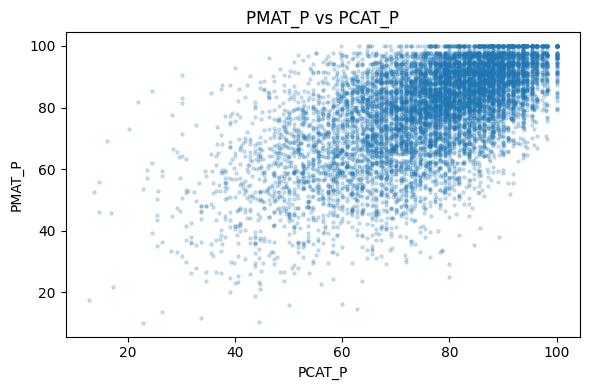

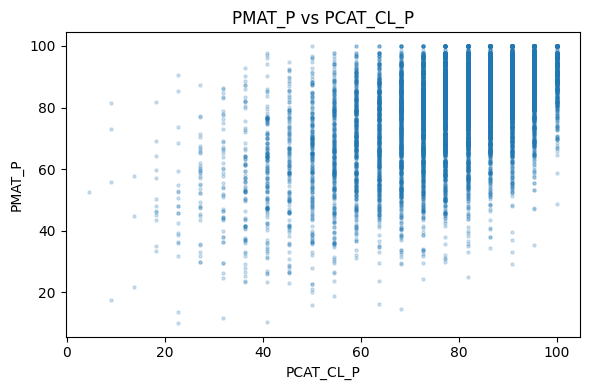

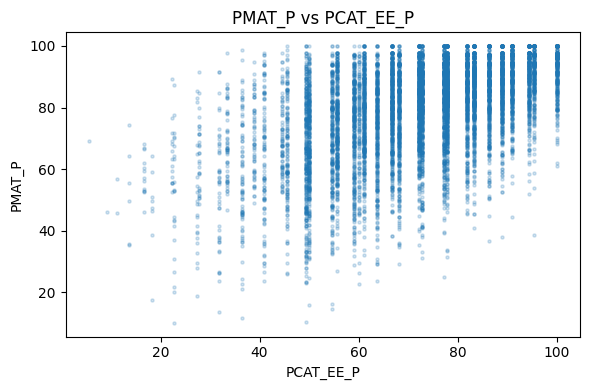

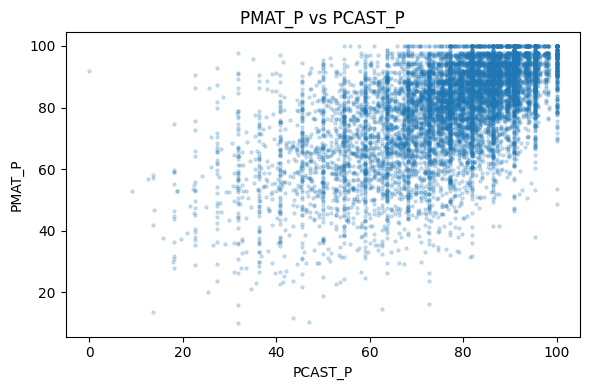

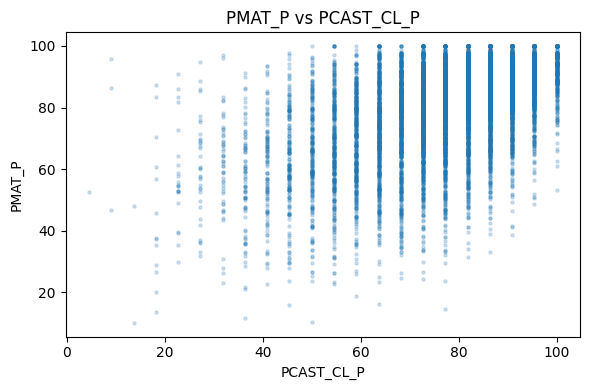

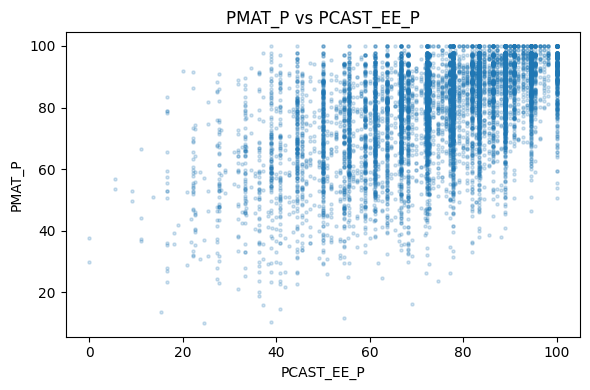

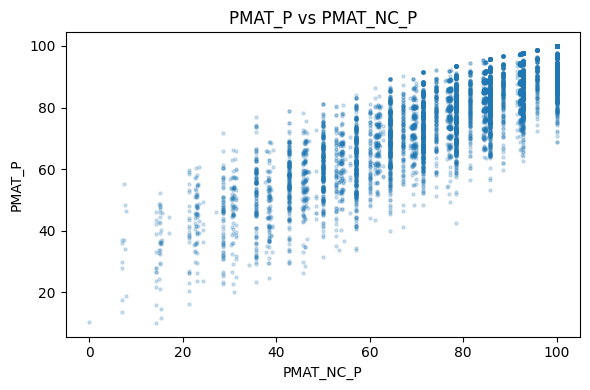

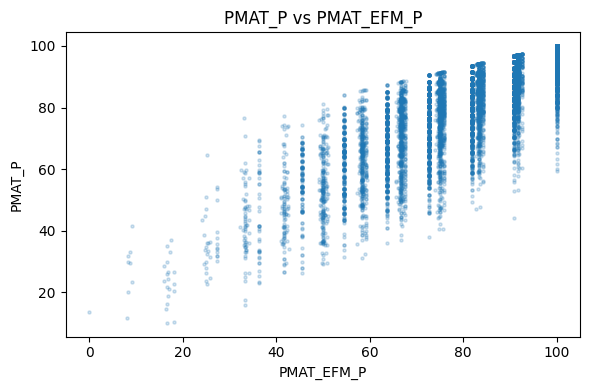

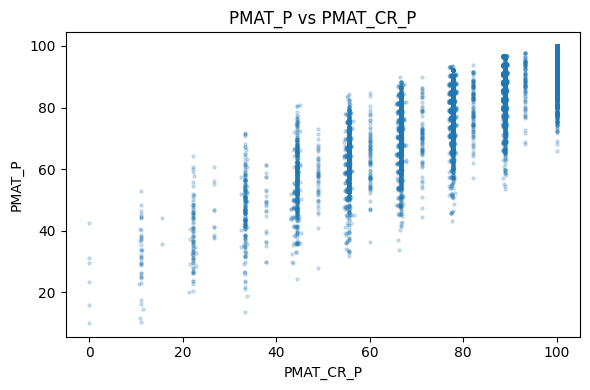

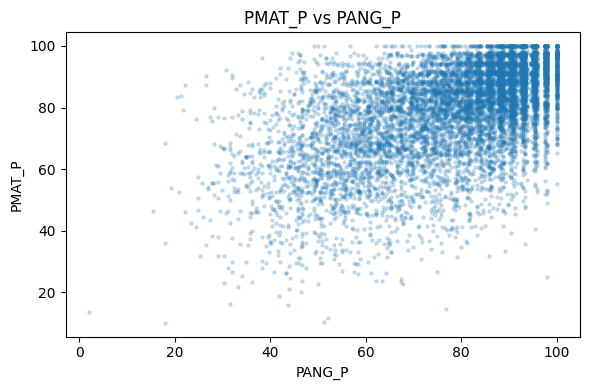

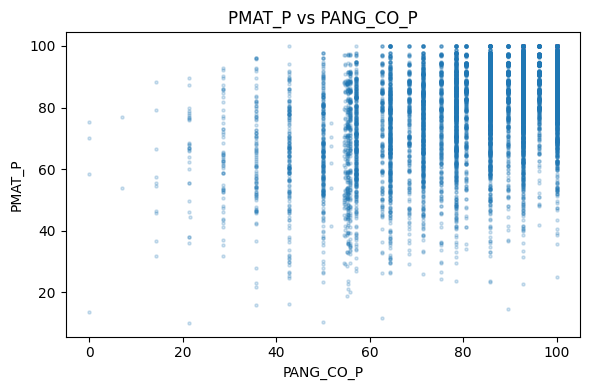

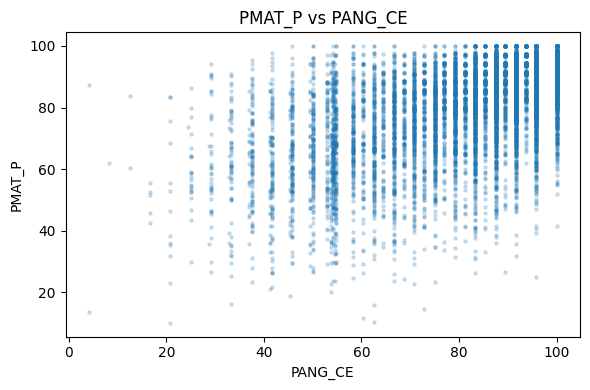

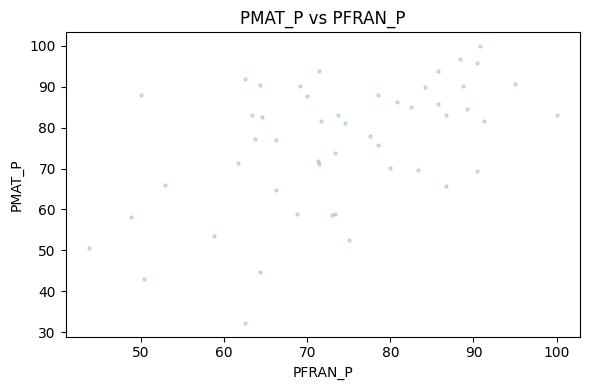

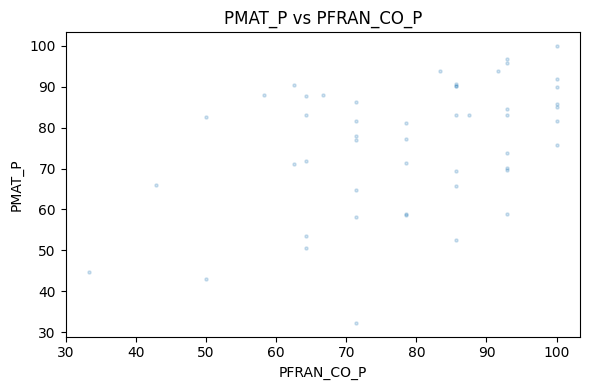

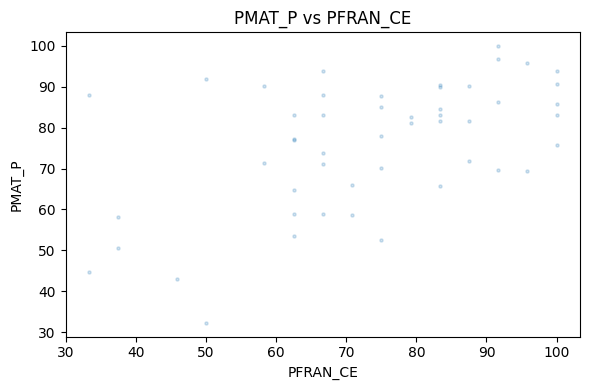

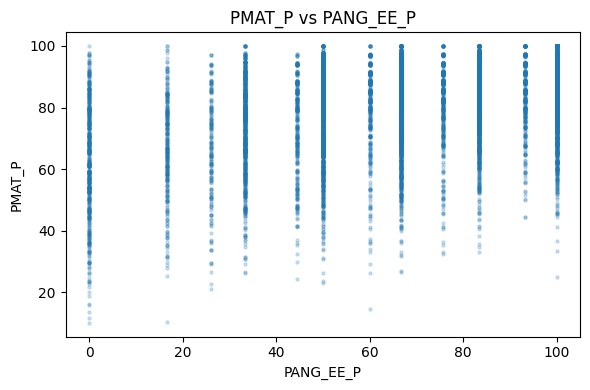

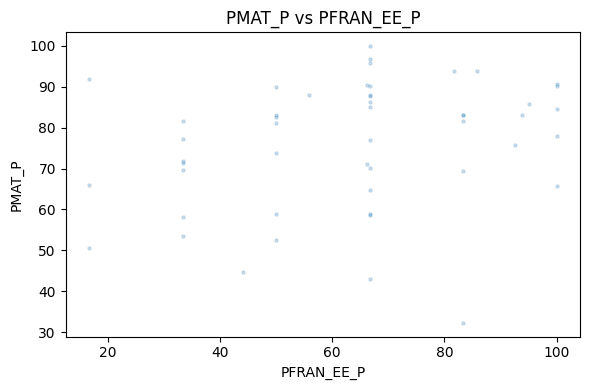

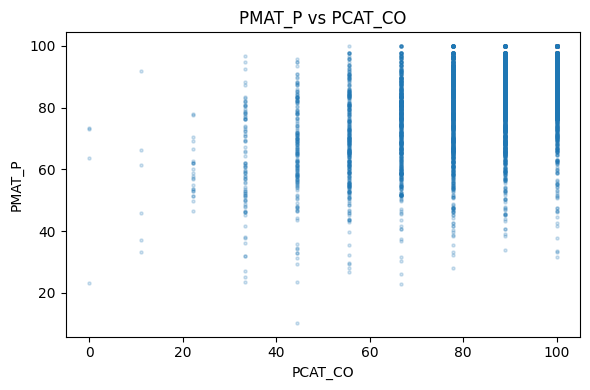

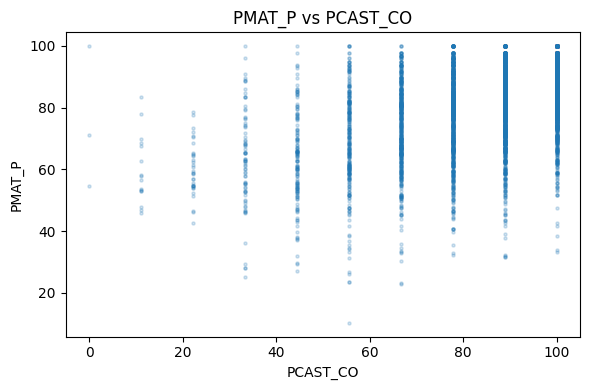

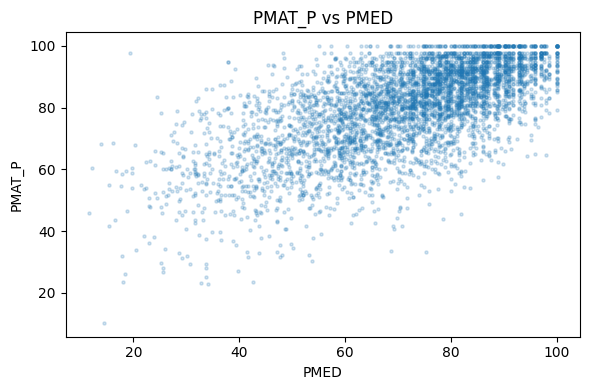

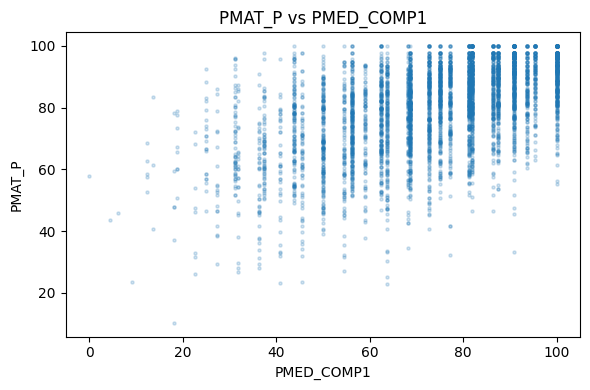

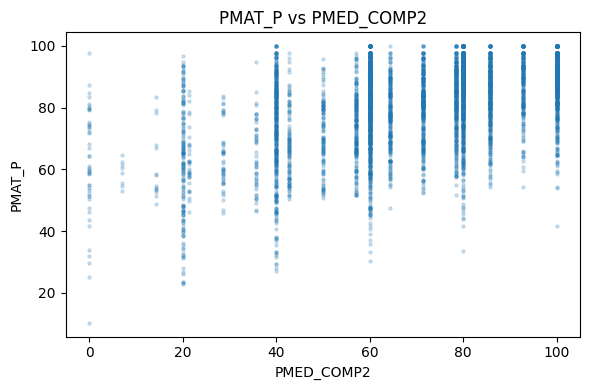

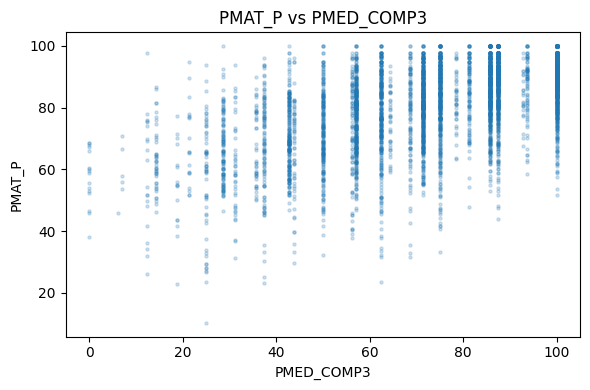

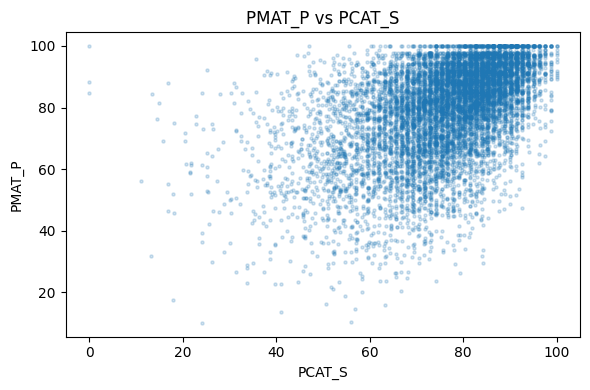

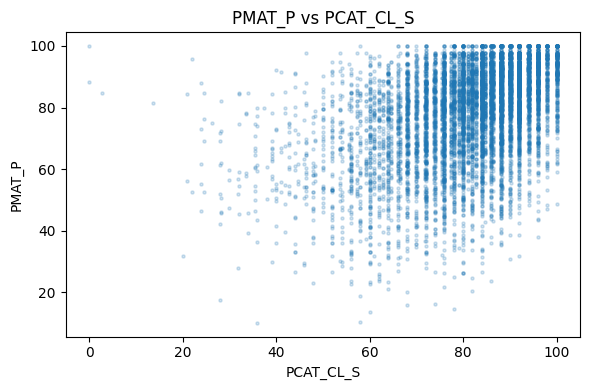

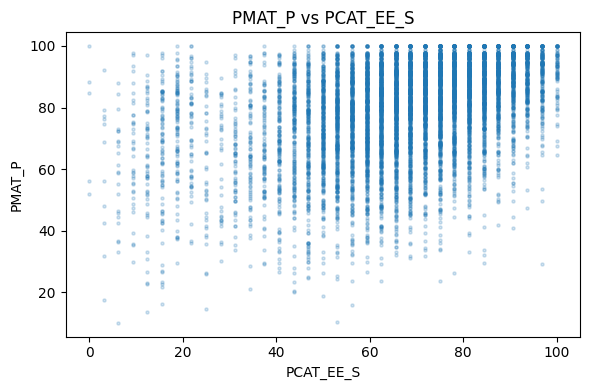

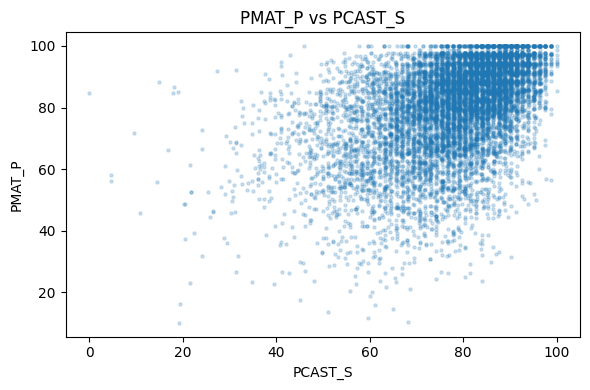

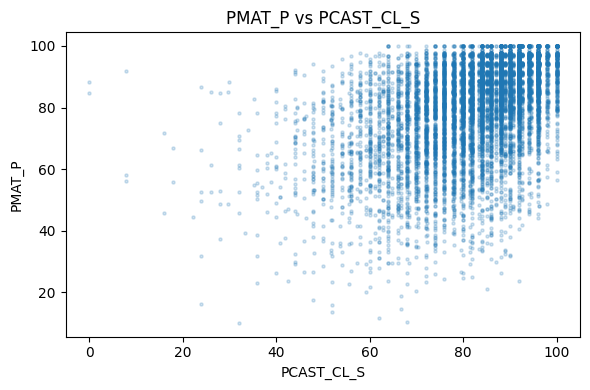

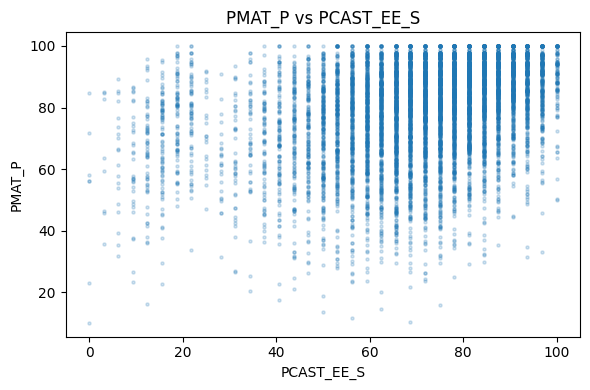

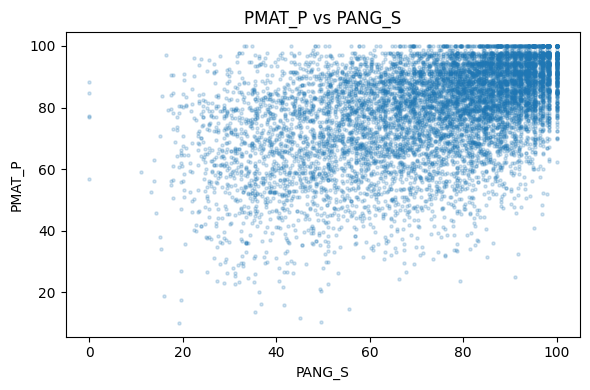

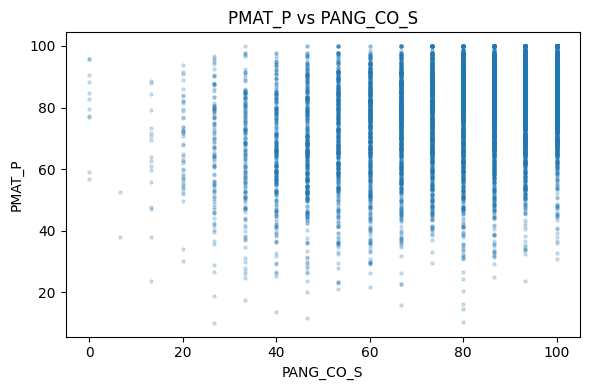

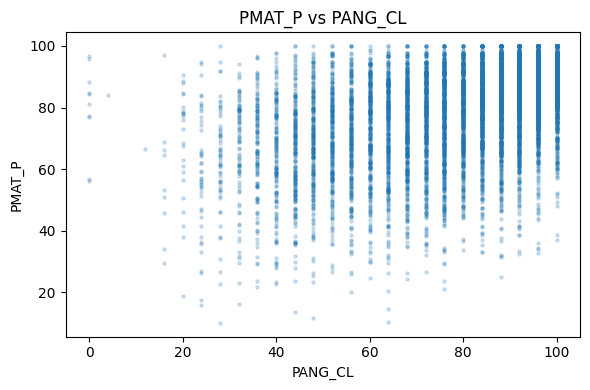

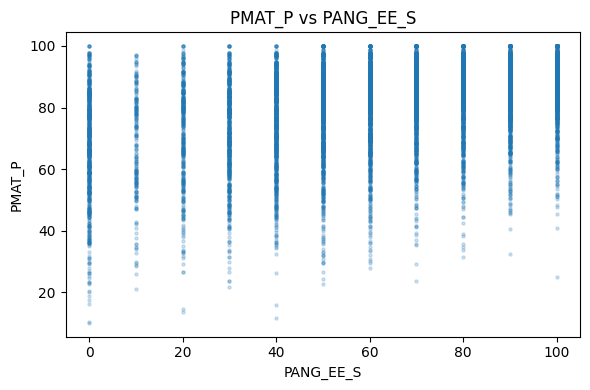

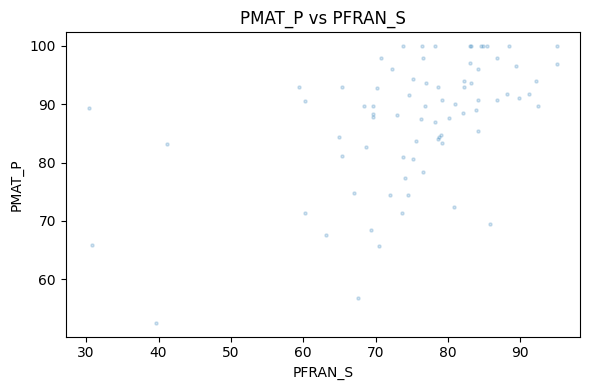

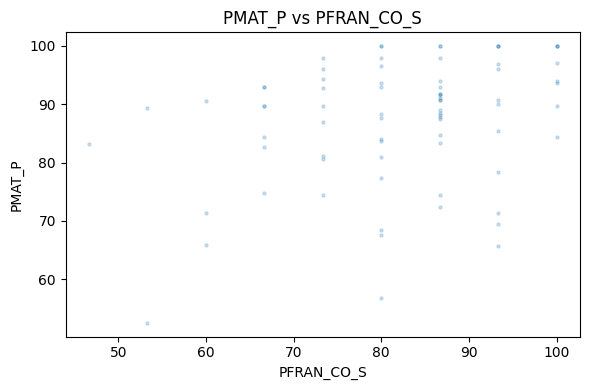

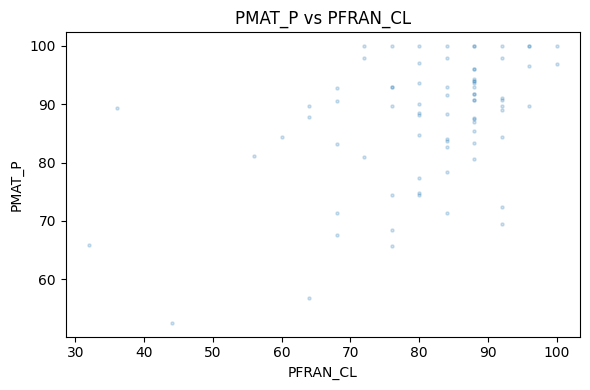

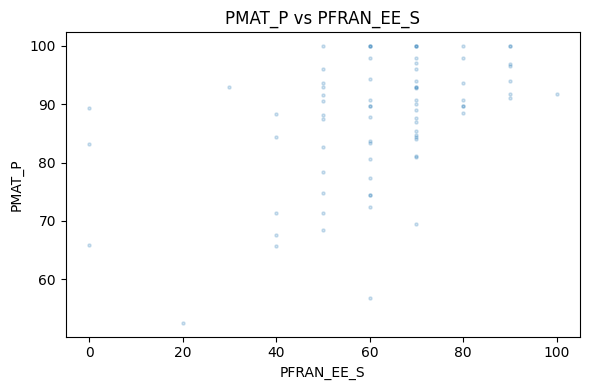

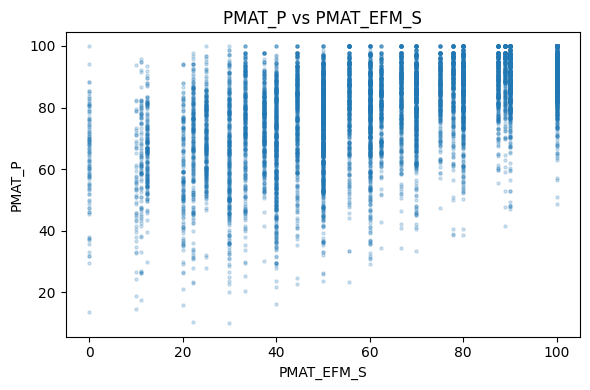

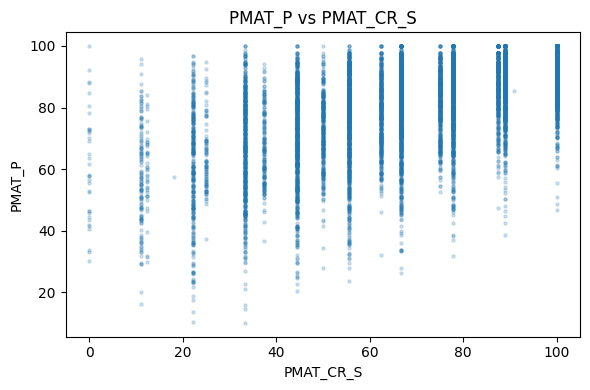

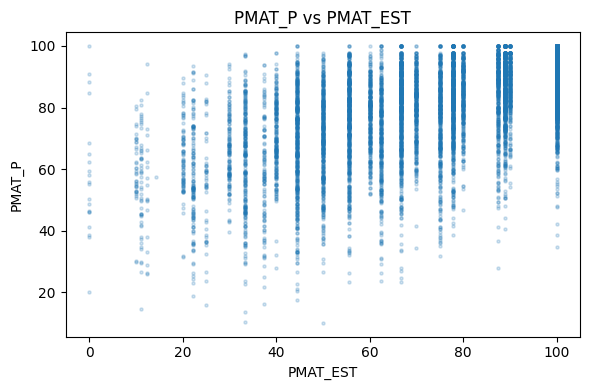

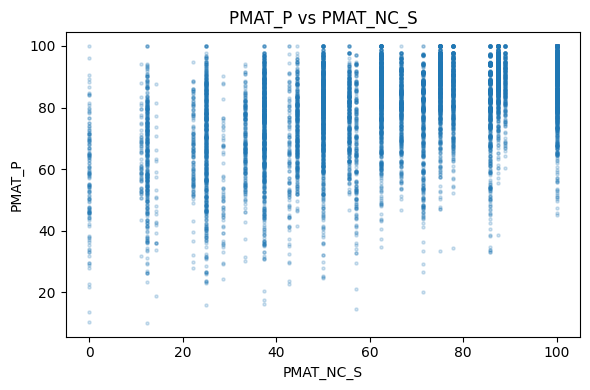

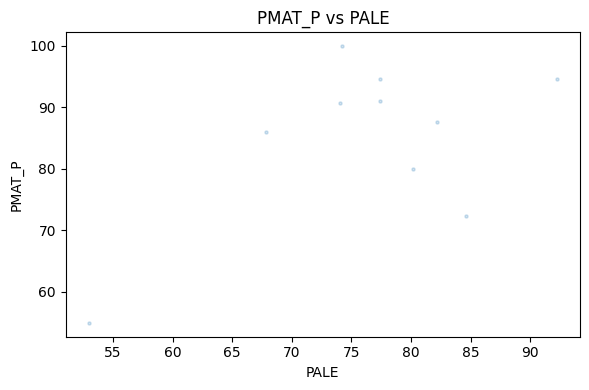

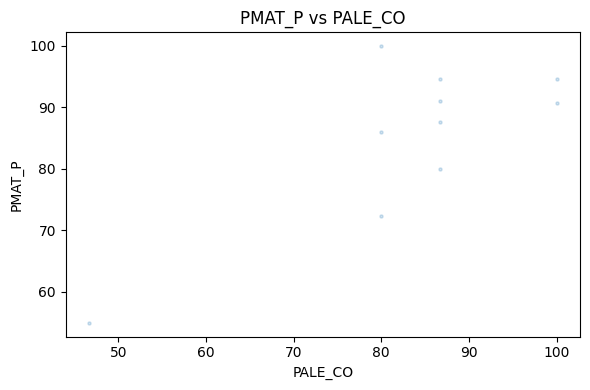

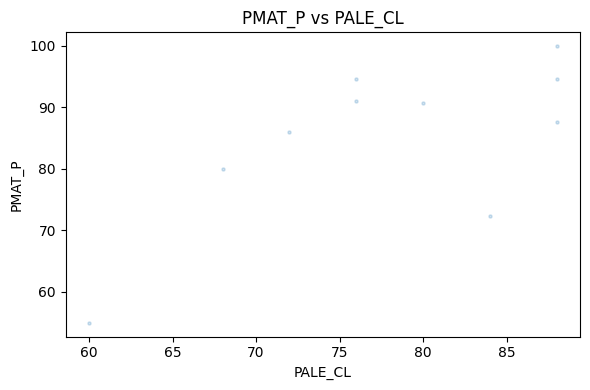

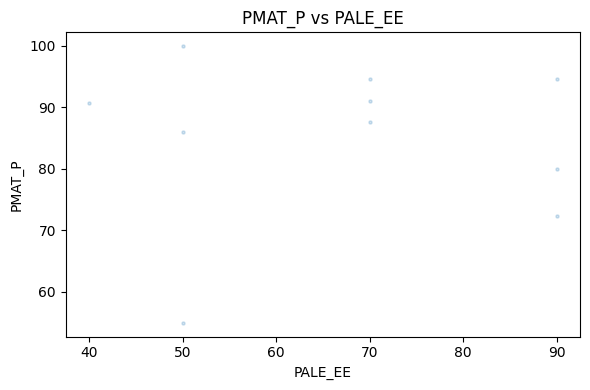

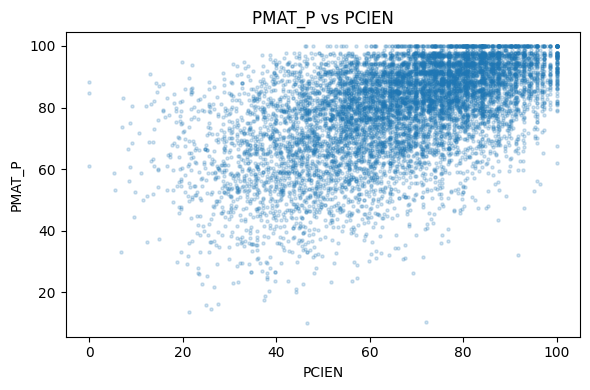

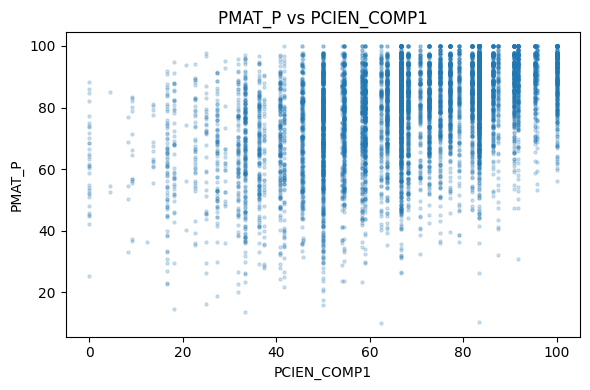

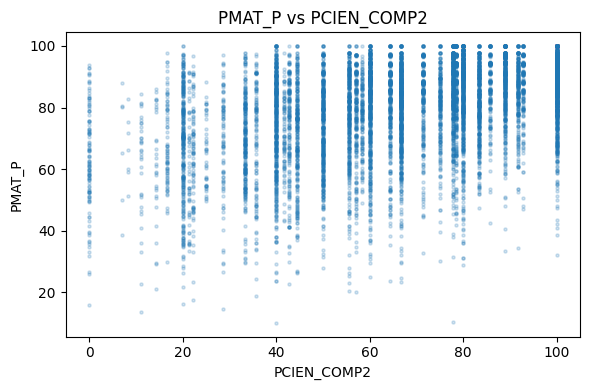

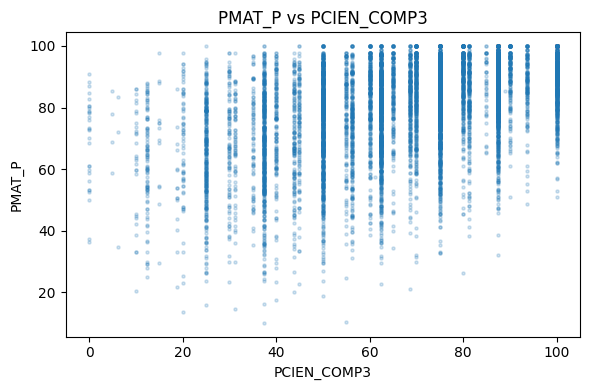

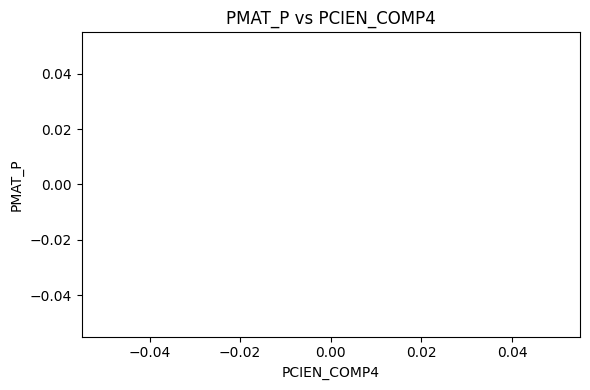

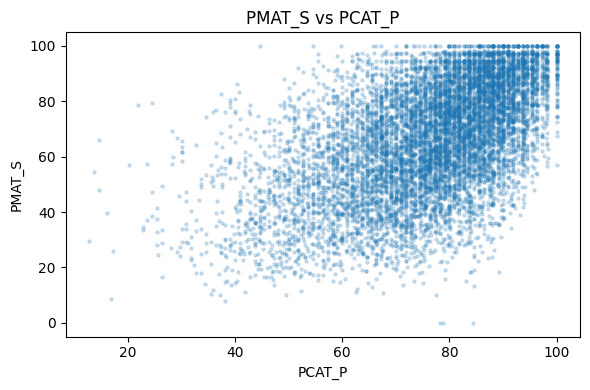

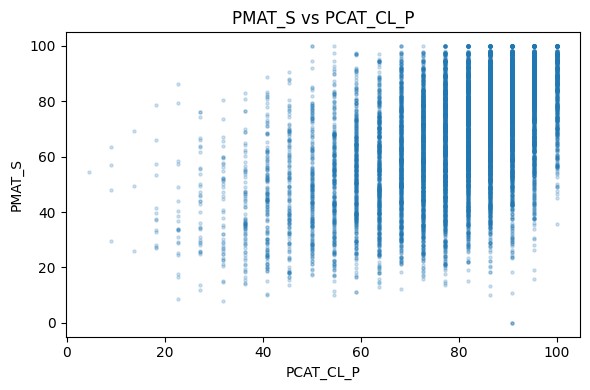

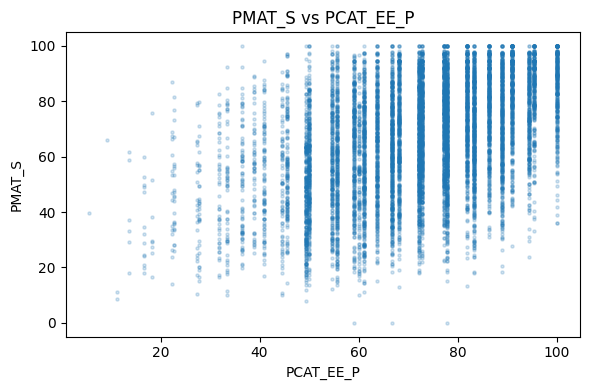

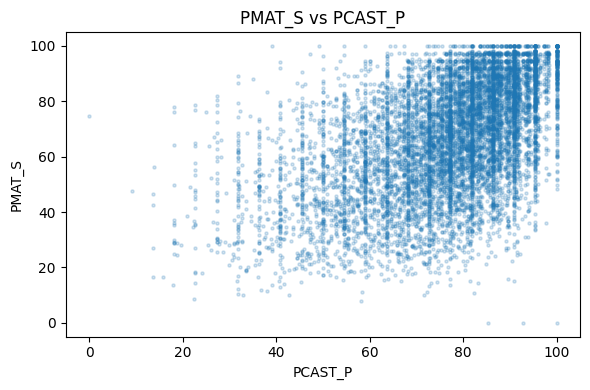

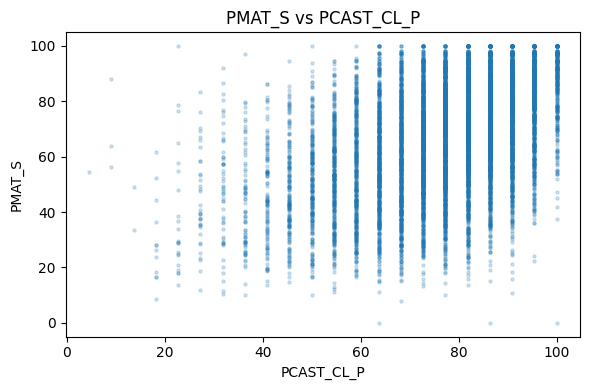

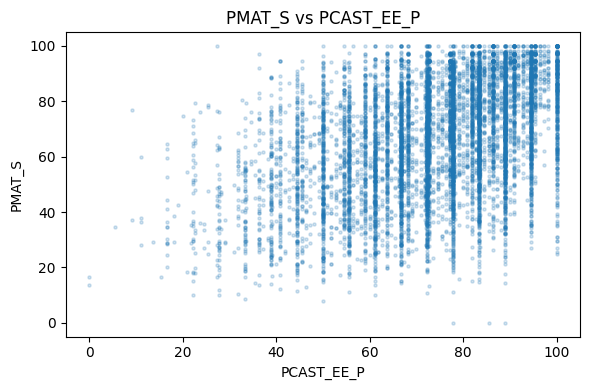

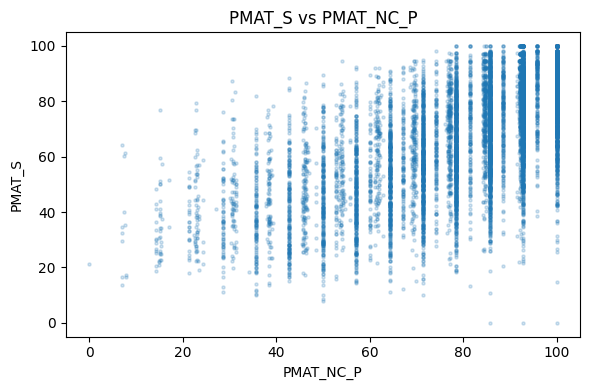

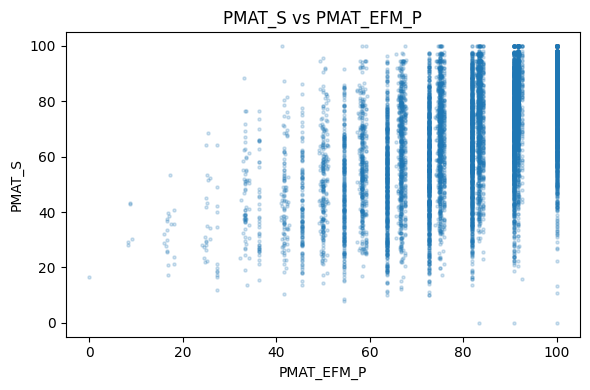

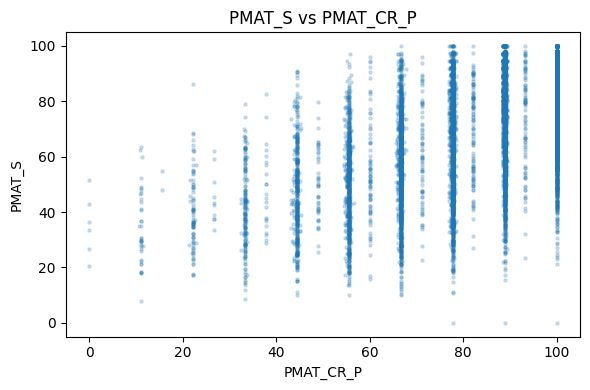

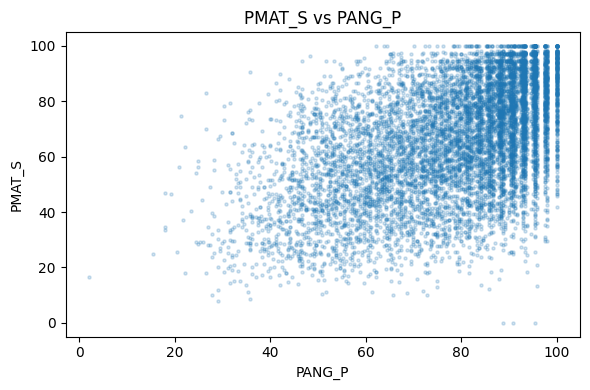

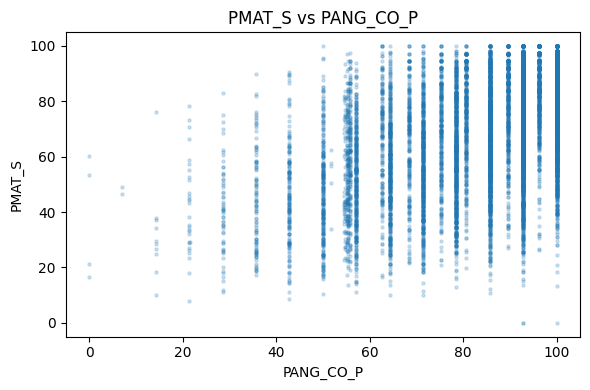

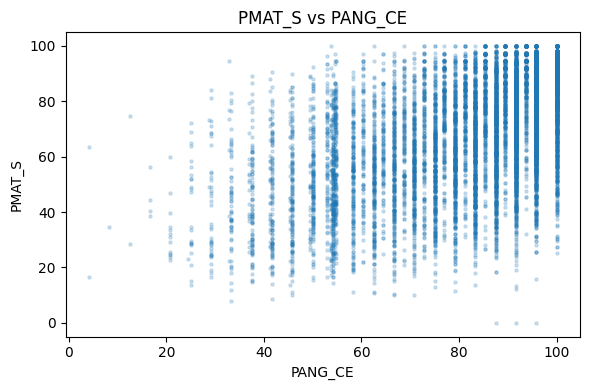

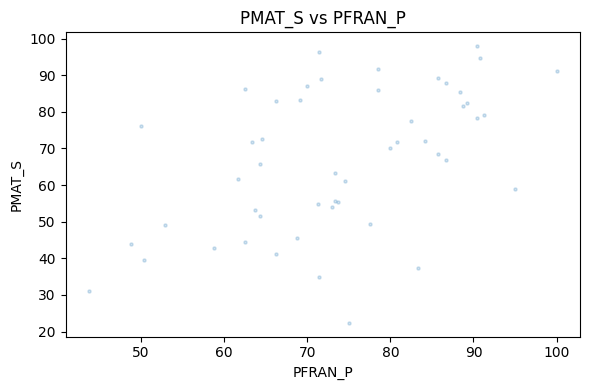

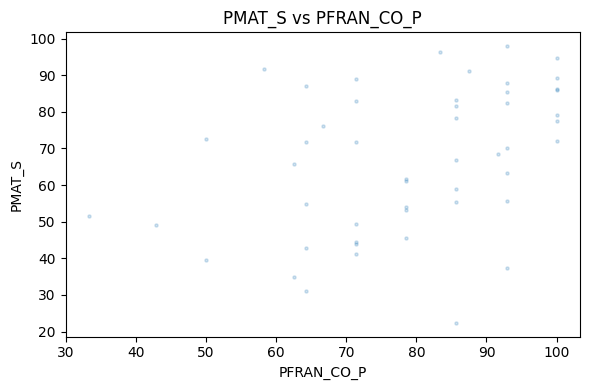

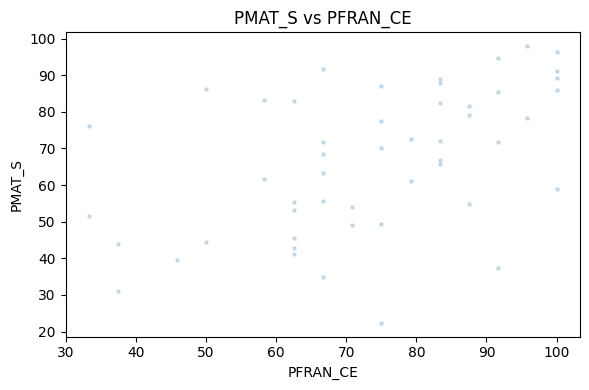

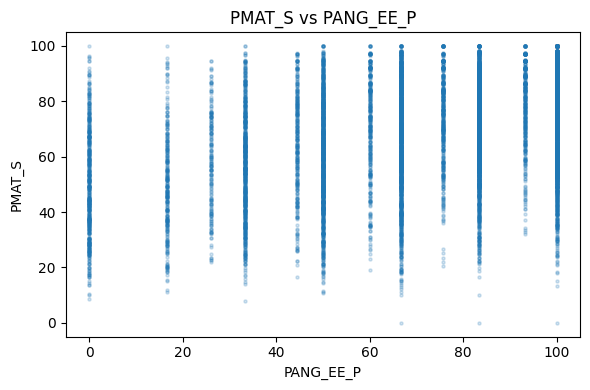

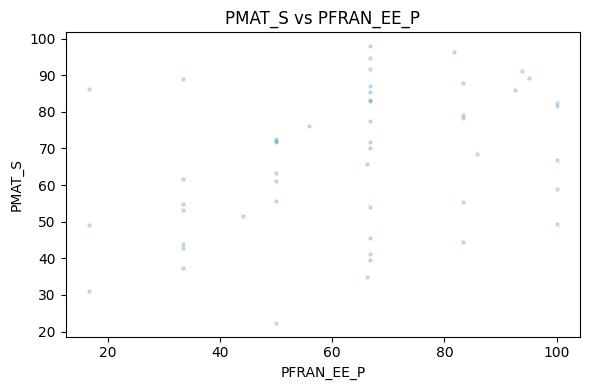

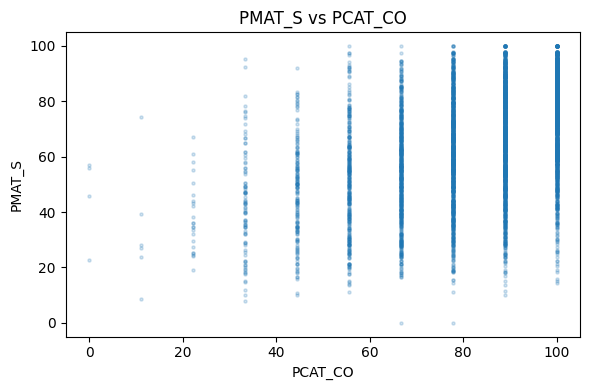

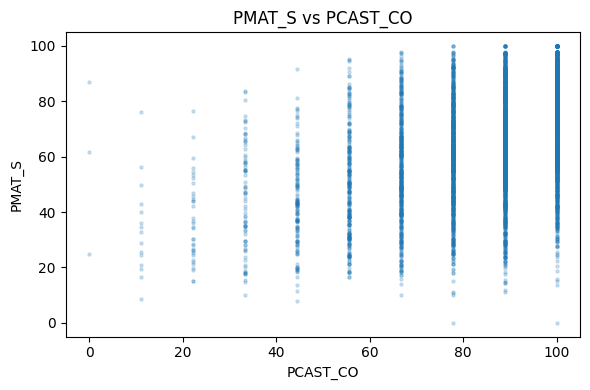

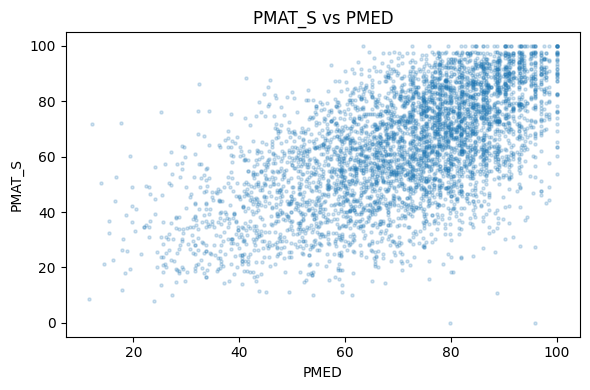

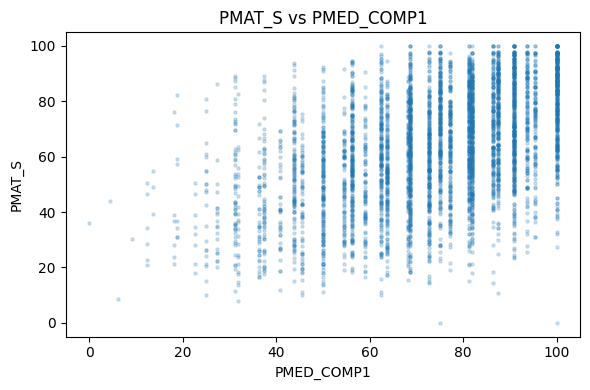

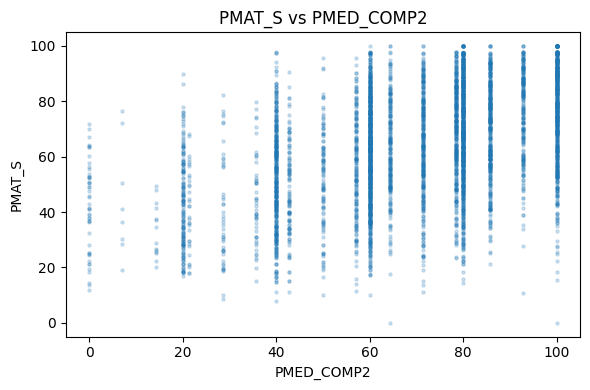

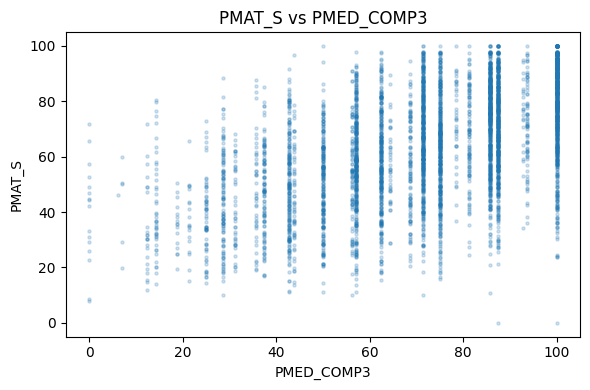

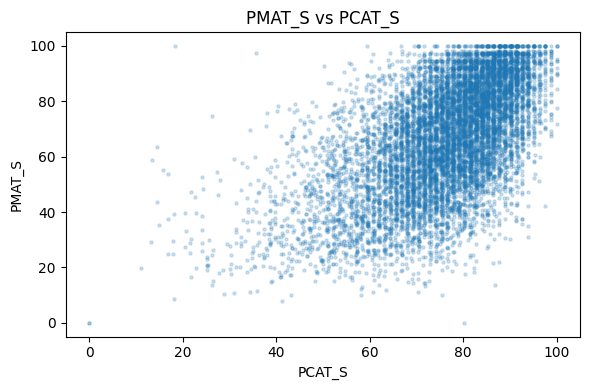

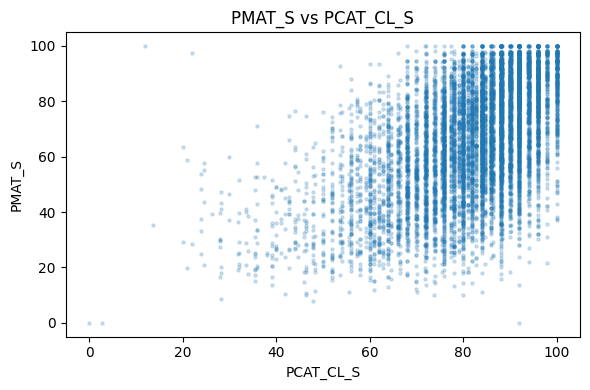

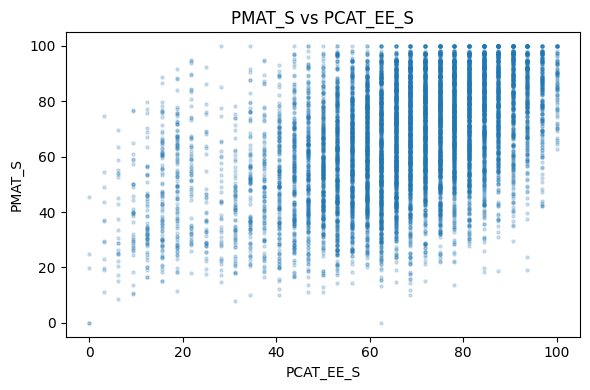

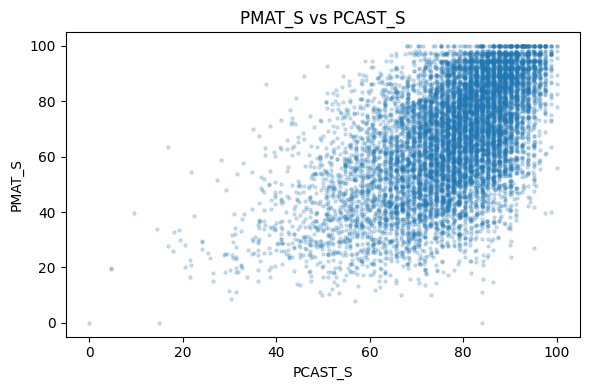

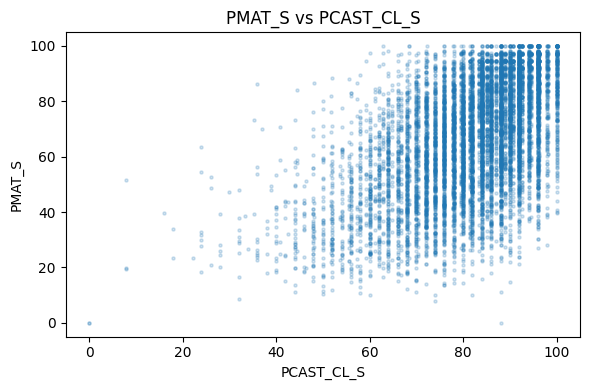

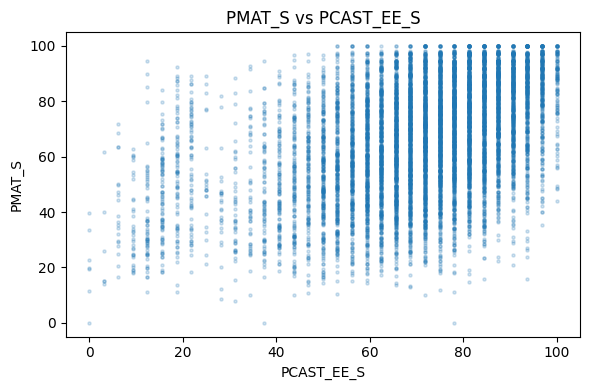

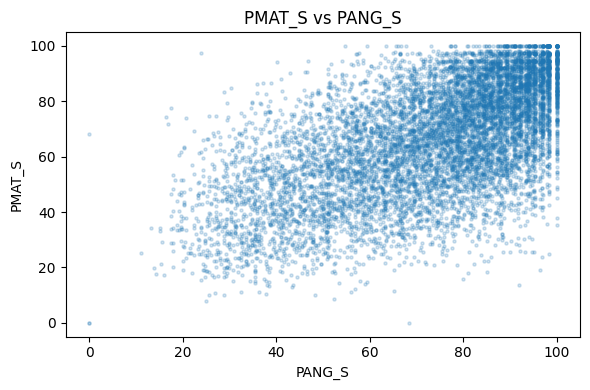

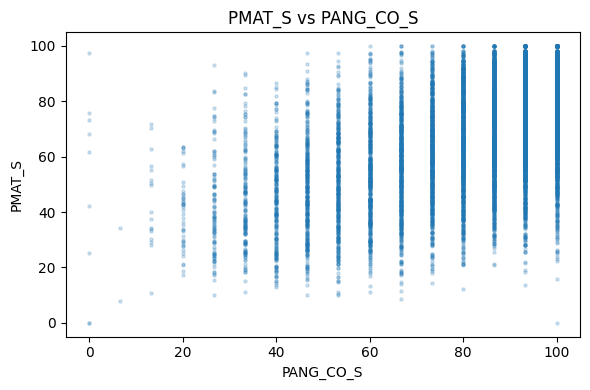

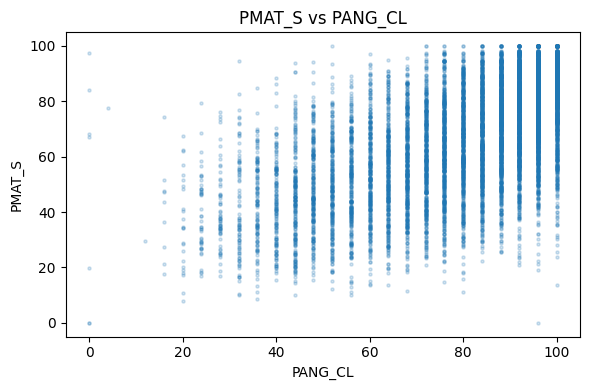

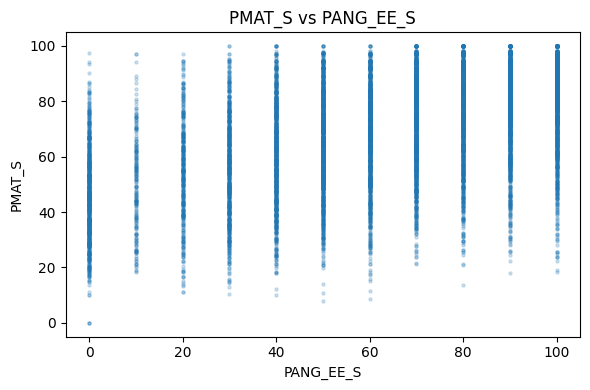

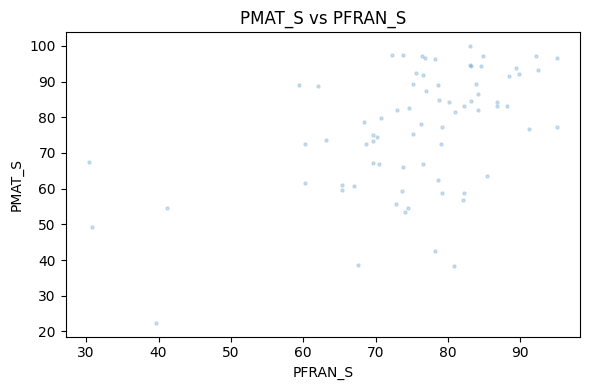

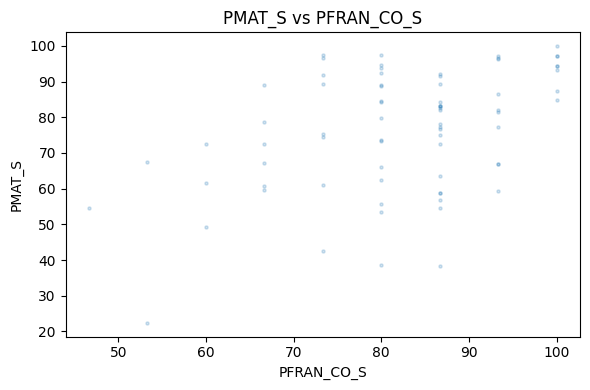

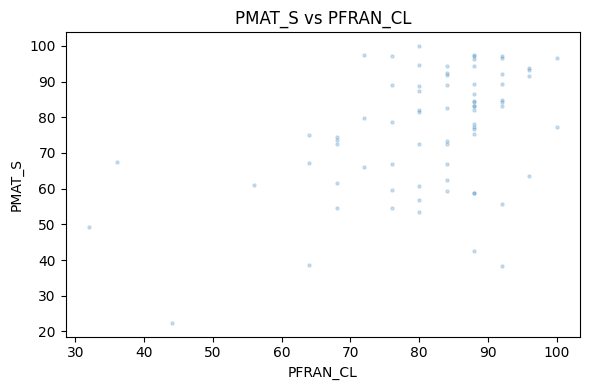

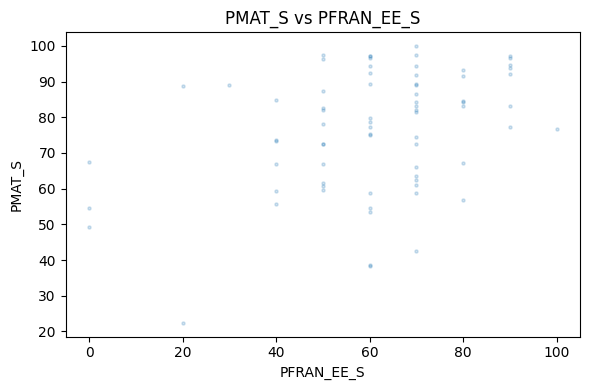

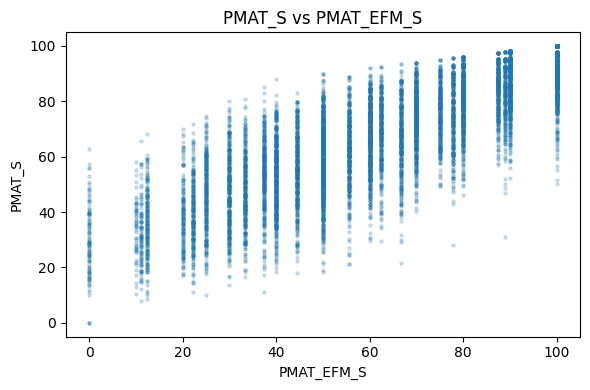

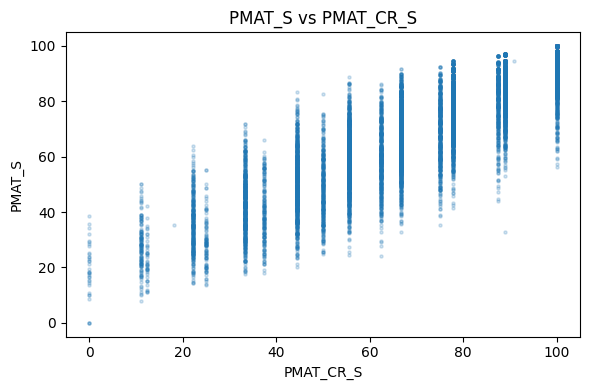

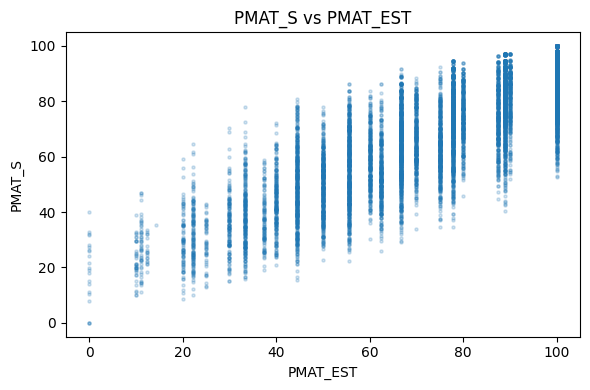

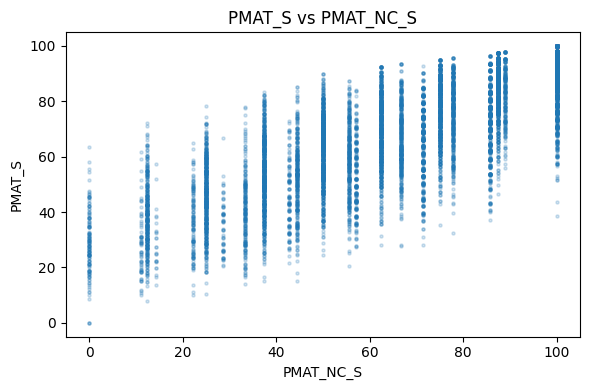

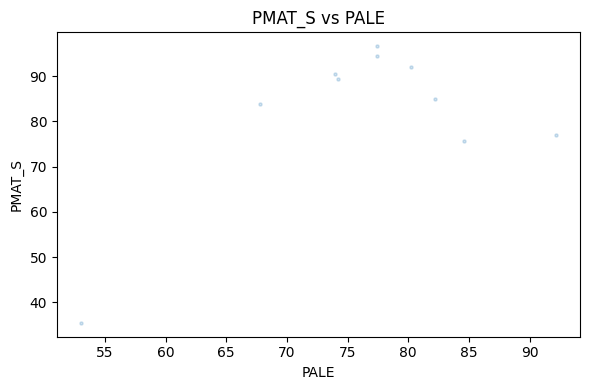

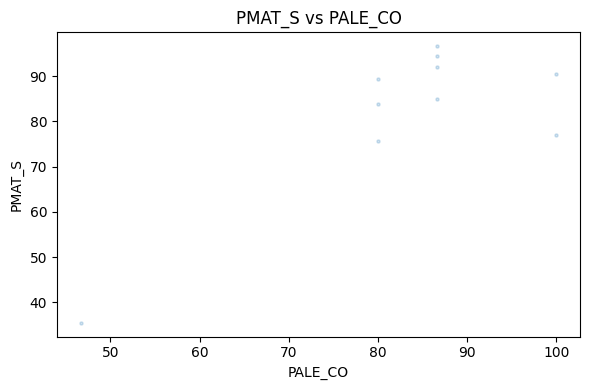

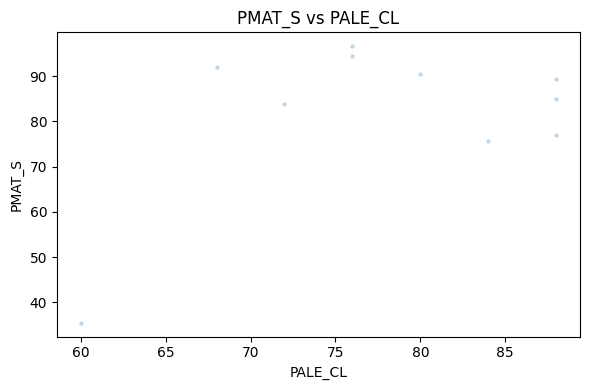

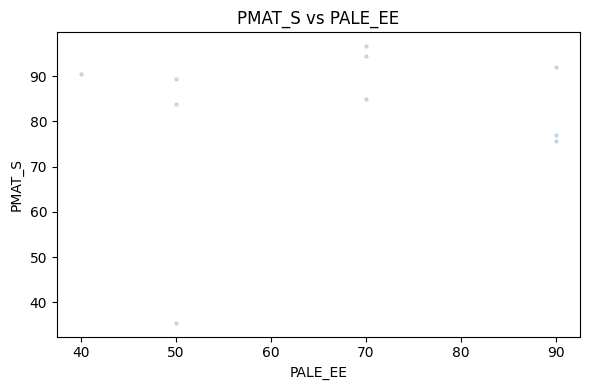

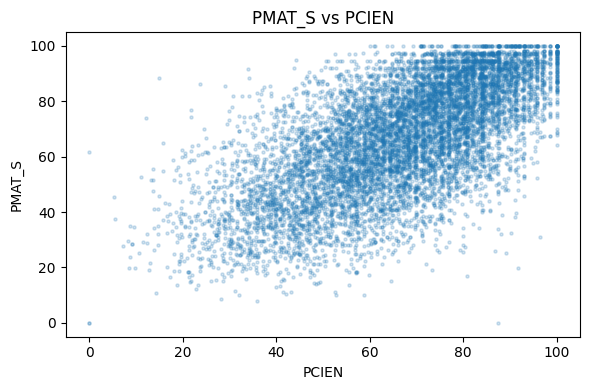

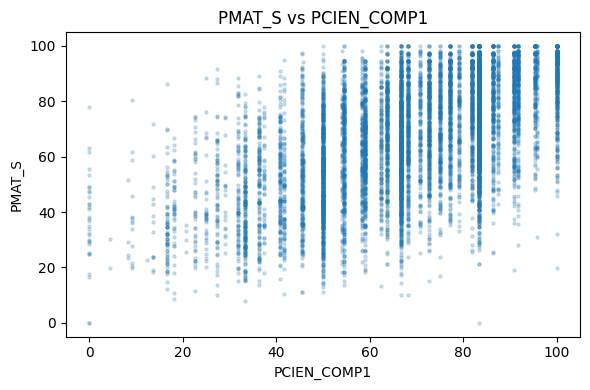

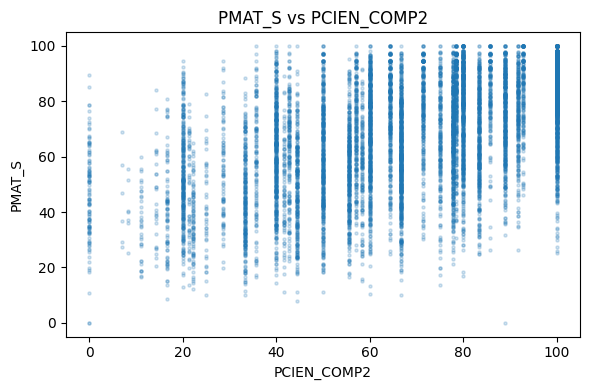

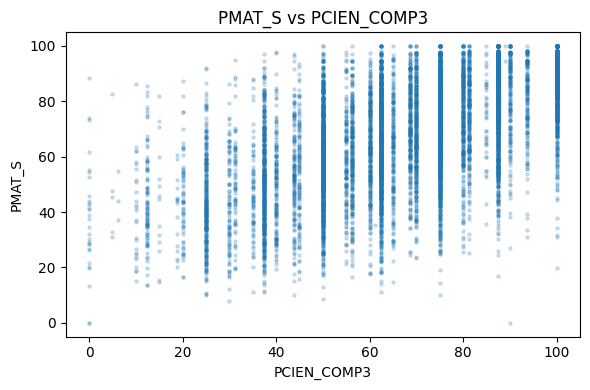

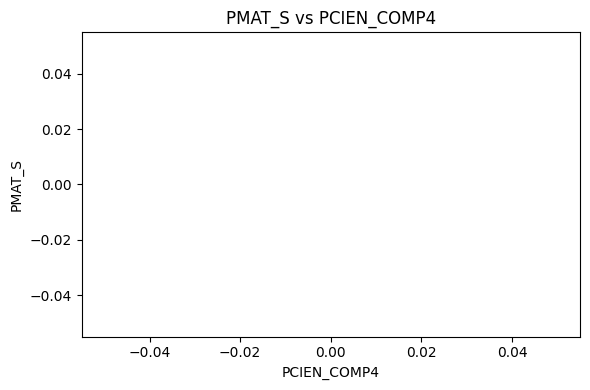

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Detectar totes les columnes de notes (comencen per "P")
note_cols_all = [c for c in df_merged.columns if c.startswith('P')]

# Per seguretat, assegurem que PMAT_P i PMAT_S hi siguin
print("Columnes de notes trobades:")
print(note_cols_all)

# 2) Convertir totes les notes a numèriques (coma → punt, string → float)
for col in note_cols_all:
    # Pas 1: assegurar tipus string
    s = df_merged[col].astype(str)
    # Pas 2: substituir comes per punts
    s = s.str.replace(',', '.', regex=False)
    # Pas 3: convertir a numèric, valors no convertibles → NaN
    df_merged[col] = pd.to_numeric(s, errors='coerce')

# 3) Separar matemàtiques i resta de notes
math_cols = ['PMAT_P', 'PMAT_S']
other_note_cols = [c for c in note_cols_all if c not in math_cols]

# 4) Calcular correlacions de matemàtiques amb la resta
corr_with_mat_P = df_merged[other_note_cols + ['PMAT_P']].corr(numeric_only=True)['PMAT_P'].sort_values(ascending=False)
corr_with_mat_S = df_merged[other_note_cols + ['PMAT_S']].corr(numeric_only=True)['PMAT_S'].sort_values(ascending=False)

print("\nCorrelacions amb Matemàtiques P (PMAT_P):")
print(corr_with_mat_P)

print("\nCorrelacions amb Matemàtiques S (PMAT_S):")
print(corr_with_mat_S)

# 5) Scatter plots: Matemàtiques vs. resta de notes
#    Per no morir en el plot, agafem una mostra aleatòria de, per exemple, 10.000 alumnes
max_points = 10000
if len(df_merged) > max_points:
    df_plot = df_merged.sample(n=max_points, random_state=0)
else:
    df_plot = df_merged

for m in math_cols:
    for col in other_note_cols:
        plt.figure(figsize=(6, 4))
        plt.scatter(df_plot[col], df_plot[m], alpha=0.2, s=5)
        plt.xlabel(col)
        plt.ylabel(m)
        plt.title(f"{m} vs {col}")
        plt.tight_layout()
        plt.show()
